In [1]:
import pandas as pd

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier

In [3]:
from sklearn.model_selection import cross_val_score

In [4]:
from numpy import std

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def positions_assigned_correctly(x):
    if std(x.tolist()) != 0:
        return 0
    else:
        return 1

In [7]:
soloq_df = pd.read_excel('8-18_dataset.xlsx')

In [8]:
slo_df = pd.read_excel('slo_dataset.xlsx')

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [10]:
newdf = slo_df.select_dtypes(include=numerics)
newdf2 = soloq_df.select_dtypes(include=numerics)

In [11]:
newdf.drop([col for col in newdf.columns if 'Id' in col], axis=1, inplace=True)
newdf2.drop([col for col in newdf2.columns if 'Id' in col], axis=1, inplace=True)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
newdf.drop('season', axis=1, inplace=True)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
perkp_df = slo_df.perkPrimaryStyle_name.str.get_dummies()
perks_df = slo_df.perkSubStyle_name.str.get_dummies()

perkp_df2 = soloq_df.perkPrimaryStyle_name.str.get_dummies()
perks_df2 = soloq_df.perkSubStyle_name.str.get_dummies()

In [14]:
role_dum = slo_df.role.str.get_dummies()
lane_dum = slo_df.lane.str.get_dummies()

role_dum2 = soloq_df.role.str.get_dummies()
lane_dum2 = soloq_df.lane.str.get_dummies()

In [15]:
lane_dum2.drop('NONE', axis=1, inplace=True)

In [16]:
champ_df = slo_df.champ_name.str.get_dummies()

champ_df2 = soloq_df.champ_name.str.get_dummies()

In [17]:
all_num_df = pd.concat([newdf, perkp_df, perks_df, champ_df, role_dum, lane_dum], axis=1)
all_num_df2 = pd.concat([newdf2, perkp_df2, perks_df2, champ_df2, role_dum2, lane_dum2], axis=1)

## Fill NA values 

In [18]:
fill_0_cols = all_num_df.T.ix[all_num_df.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [19]:
all_num_df[fill_0_cols] = all_num_df[fill_0_cols].fillna(0).astype(int)

In [20]:
all_num_df2[fill_0_cols] = all_num_df2[fill_0_cols].fillna(0).astype(int)

In [21]:
fill_mean_cols = [col for col in all_num_df2.columns if 'tt' in col]

In [22]:
all_num_df2[fill_mean_cols] = all_num_df2[fill_mean_cols].fillna(all_num_df2[fill_mean_cols].mean())

In [23]:
fill_0_cols_2 = all_num_df2.T.ix[all_num_df2.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [24]:
all_num_df2[fill_0_cols_2] = all_num_df2[fill_0_cols_2].fillna(0)

## Fill missing cols 

In [25]:
missing_cols = set(all_num_df2.columns) - set(all_num_df.columns)

In [26]:
all_num_df = all_num_df.assign(**{col: 0 for col in missing_cols})

##  Predict

### Set trainers, predictors and labels

In [27]:
trainers = all_num_df[sorted(all_num_df.columns)]
predictors = all_num_df2[sorted(all_num_df2.columns)]

In [28]:
labels = slo_df.position

### Configure all models

In [29]:
model1 = DecisionTreeClassifier()
model2 = BernoulliNB()
model3 = MLPClassifier()
model4 = SVC()
model5 = BaggingClassifier()
model6 = GradientBoostingClassifier()
model7 = RandomForestClassifier()

In [30]:
models = [model1, model2, model3, model4, model5, model6, model7]

In [31]:
models_results = pd.concat([pd.DataFrame(cross_val_score(estimator=model, cv=5, X=trainers, y=labels)).T for model in models])

In [32]:
models_results['model'] = ['DecisionTreeClassifier', 'BernoulliNB', 'MLPClassifier', 'SVC', 'BaggingClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']

In [33]:
models_results['mean'] = models_results[[0, 1, 2, 3, 4]].T.mean()

In [34]:
models_results['std'] = models_results[[0, 1, 2, 3, 4]].T.std()

In [35]:
models_results.reset_index(drop=True)

,0,1,2,3,4,model,mean,std
0,0.9350,0.9275,0.9425,0.9425,0.9400,DecisionTreeClassifier,0.9375,0.006374
1,0.9375,0.9325,0.9400,0.9275,0.9350,BernoulliNB,0.9345,0.004809
2,0.8825,0.8250,0.8450,0.8800,0.8925,MLPClassifier,0.8650,0.028668
3,0.2000,0.2000,0.2000,0.2000,0.2000,SVC,0.2000,0.000000
4,0.9450,0.9400,0.9750,0.9550,0.9500,BaggingClassifier,0.9530,0.013509
5,0.9625,0.9650,0.9800,0.9800,0.9625,GradientBoostingClassifier,0.9700,0.009186
6,0.9350,0.9450,0.9675,0.9600,0.9500,RandomForestClassifier,0.9515,0.012698


In [36]:
list1 = []

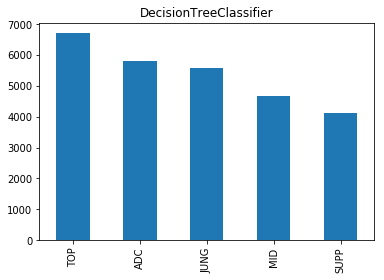

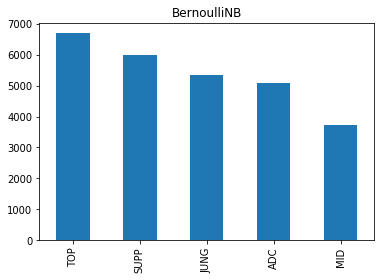

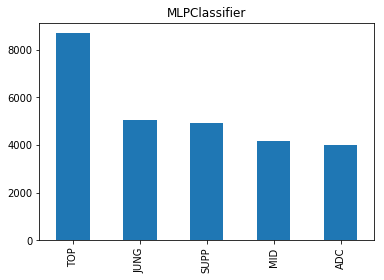

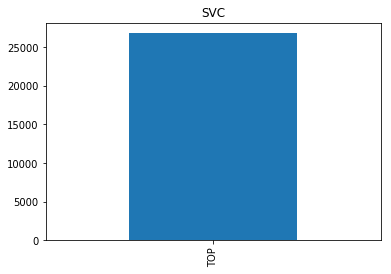

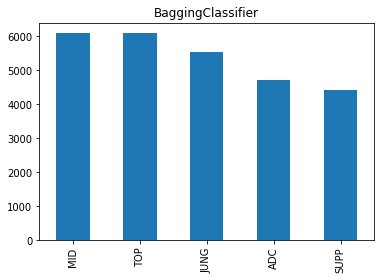

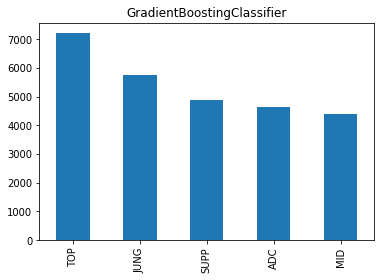

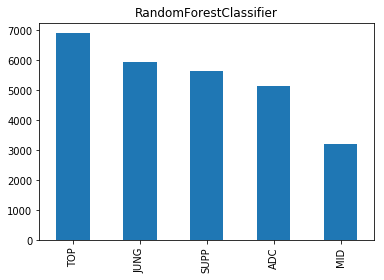

In [37]:
for model in models:
    model.fit(X=trainers, y=labels)
    predicts = model.predict(X=predictors)
    soloq_df['position'] = predicts
    
    m_name = str(model.__class__).split('\'')[-2].split('.')[-1]
    
    data = soloq_df.position.value_counts()
    data.plot(kind='bar', title=m_name)
    plt.show()
    
    soloq_df = soloq_df.assign(**{lane: 0 for lane in ['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']})
    pos_dums = soloq_df.position.str.get_dummies()
    dums_cols = pos_dums.columns.tolist()
    soloq_df[dums_cols] = pos_dums
    df_temp = soloq_df.groupby(['gameId', 'side']).sum()[['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']]
    df_temp['all_good'] = df_temp.apply(positions_assigned_correctly, axis=1)
    good_predicts = df_temp.all_good.count()
    
    list1.append({'model': m_name, 'predicts': predicts, 'good_predicts': good_predicts})

In [38]:
predicts_df = pd.DataFrame(list1)

In [39]:
for row in predicts_df.iterrows():
    print(row[1][0])
    print(pd.Series(row[1][1]).value_counts())
    print('\n')

5372
DecisionTreeClassifier    1
dtype: int64


5372
BernoulliNB    1
dtype: int64


5372
MLPClassifier    1
dtype: int64


5372
SVC    1
dtype: int64


5372
BaggingClassifier    1
dtype: int64


5372
GradientBoostingClassifier    1
dtype: int64


5372
RandomForestClassifier    1
dtype: int64




# Predictions with only champion, runes and role/lane info 

In [40]:
all_num_df = pd.concat([perkp_df, perks_df, champ_df, role_dum, lane_dum], axis=1)
all_num_df2 = pd.concat([perkp_df2, perks_df2, champ_df2, role_dum2, lane_dum2], axis=1)

## Fill NA values 

In [41]:
fill_0_cols = all_num_df.T.ix[all_num_df.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [42]:
all_num_df[fill_0_cols] = all_num_df[fill_0_cols].fillna(0).astype(int)

In [43]:
all_num_df2[fill_0_cols] = all_num_df2[fill_0_cols].fillna(0).astype(int)

In [44]:
fill_mean_cols = [col for col in all_num_df2.columns if 'tt' in col]

In [45]:
all_num_df2[fill_mean_cols] = all_num_df2[fill_mean_cols].fillna(all_num_df2[fill_mean_cols].mean())

## Fill NA values 

In [46]:
fill_0_cols = all_num_df.T.ix[all_num_df.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [47]:
all_num_df[fill_0_cols] = all_num_df[fill_0_cols].fillna(0).astype(int)

In [48]:
all_num_df2[fill_0_cols] = all_num_df2[fill_0_cols].fillna(0).astype(int)

In [49]:
fill_mean_cols = [col for col in all_num_df2.columns if 'tt' in col]

In [50]:
all_num_df2[fill_mean_cols] = all_num_df2[fill_mean_cols].fillna(all_num_df2[fill_mean_cols].mean())

In [51]:
fill_0_cols_2 = all_num_df2.T.ix[all_num_df2.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [52]:
all_num_df2[fill_0_cols_2] = all_num_df2[fill_0_cols_2].fillna(0)

## Fill missing cols 

In [53]:
missing_cols = set(all_num_df2.columns) - set(all_num_df.columns)

In [54]:
all_num_df = all_num_df.assign(**{col: 0 for col in missing_cols})

##  Predict

### Set trainers, predictors and labels

In [55]:
trainers = all_num_df[sorted(all_num_df.columns)]
predictors = all_num_df2[sorted(all_num_df2.columns)]

In [56]:
labels = slo_df.position

### Configure all models

In [57]:
model1 = DecisionTreeClassifier()
model2 = BernoulliNB()
model3 = MLPClassifier()
model4 = SVC()
model5 = BaggingClassifier()
model6 = GradientBoostingClassifier()
model7 = RandomForestClassifier()

In [58]:
models = [model1, model2, model3, model4, model5, model6, model7]

In [59]:
models_results = pd.concat([pd.DataFrame(cross_val_score(estimator=model, cv=5, X=trainers, y=labels)).T for model in models])

In [60]:
models_results['model'] = ['DecisionTreeClassifier', 'BernoulliNB', 'MLPClassifier', 'SVC', 'BaggingClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']

In [61]:
models_results['mean'] = models_results[[0, 1, 2, 3, 4]].T.mean()

In [62]:
models_results['std'] = models_results[[0, 1, 2, 3, 4]].T.std()

In [63]:
models_results.reset_index(drop=True)

,0,1,2,3,4,model,mean,std
0,0.9375,0.9175,0.9250,0.9025,0.915,DecisionTreeClassifier,0.9195,0.012918
1,0.9075,0.8900,0.8775,0.8525,0.880,BernoulliNB,0.8815,0.020047
2,0.9525,0.9525,0.9650,0.9500,0.950,MLPClassifier,0.9540,0.006275
3,0.8350,0.8000,0.7625,0.7750,0.800,SVC,0.7945,0.027861
4,0.9325,0.9200,0.9225,0.9025,0.910,BaggingClassifier,0.9175,0.011592
5,0.9400,0.9450,0.9475,0.9400,0.945,GradientBoostingClassifier,0.9435,0.003354
6,0.9300,0.9125,0.9125,0.8950,0.900,RandomForestClassifier,0.9100,0.013578


In [64]:
list1 = []

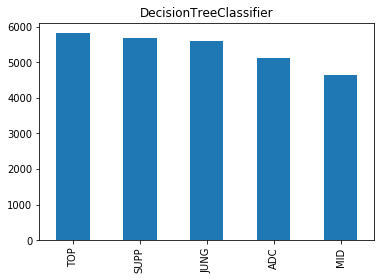

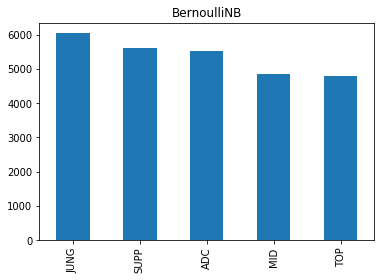

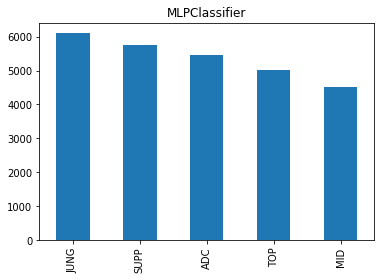

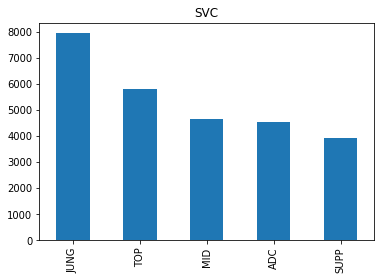

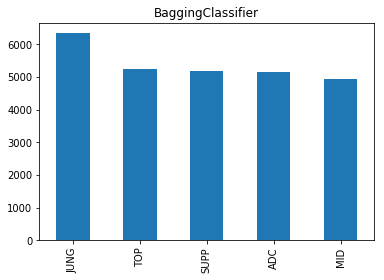

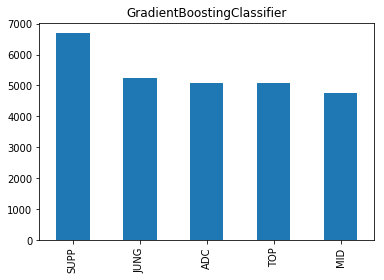

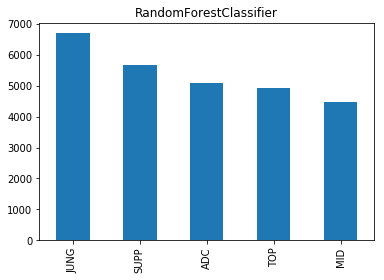

In [65]:
for model in models:
    model.fit(X=trainers, y=labels)
    predicts = model.predict(X=predictors)
    soloq_df['position'] = predicts
    
    m_name = str(model.__class__).split('\'')[-2].split('.')[-1]
    
    data = soloq_df.position.value_counts()
    data.plot(kind='bar', title=m_name)
    plt.show()
    
    soloq_df = soloq_df.assign(**{lane: 0 for lane in ['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']})
    pos_dums = soloq_df.position.str.get_dummies()
    dums_cols = pos_dums.columns.tolist()
    soloq_df[dums_cols] = pos_dums
    df_temp = soloq_df.groupby(['gameId', 'side']).sum()[['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']]
    df_temp['all_good'] = df_temp.apply(positions_assigned_correctly, axis=1)
    good_predicts = df_temp.all_good.count()
    
    list1.append({'model': m_name, 'predicts': predicts, 'good_predicts': good_predicts})

In [66]:
predicts_df = pd.DataFrame(list1)

In [67]:
for row in predicts_df.iterrows():
    print(row[1][0])
    print(pd.Series(row[1][1]).value_counts())
    print('\n')

5372
DecisionTreeClassifier    1
dtype: int64


5372
BernoulliNB    1
dtype: int64


5372
MLPClassifier    1
dtype: int64


5372
SVC    1
dtype: int64


5372
BaggingClassifier    1
dtype: int64


5372
GradientBoostingClassifier    1
dtype: int64


5372
RandomForestClassifier    1
dtype: int64




# Predictions with only champion and role/lane info 

In [68]:
all_num_df = pd.concat([champ_df, role_dum, lane_dum], axis=1)
all_num_df2 = pd.concat([champ_df2, role_dum2, lane_dum2], axis=1)

## Fill NA values 

In [69]:
fill_0_cols = all_num_df.T.ix[all_num_df.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [70]:
all_num_df[fill_0_cols] = all_num_df[fill_0_cols].fillna(0).astype(int)

In [71]:
all_num_df2[fill_0_cols] = all_num_df2[fill_0_cols].fillna(0).astype(int)

In [72]:
fill_mean_cols = [col for col in all_num_df2.columns if 'tt' in col]

In [73]:
all_num_df2[fill_mean_cols] = all_num_df2[fill_mean_cols].fillna(all_num_df2[fill_mean_cols].mean())

## Fill NA values 

In [74]:
fill_0_cols = all_num_df.T.ix[all_num_df.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [75]:
all_num_df[fill_0_cols] = all_num_df[fill_0_cols].fillna(0).astype(int)

In [76]:
all_num_df2[fill_0_cols] = all_num_df2[fill_0_cols].fillna(0).astype(int)

In [77]:
fill_mean_cols = [col for col in all_num_df2.columns if 'tt' in col]

In [78]:
all_num_df2[fill_mean_cols] = all_num_df2[fill_mean_cols].fillna(all_num_df2[fill_mean_cols].mean())

In [79]:
fill_0_cols_2 = all_num_df2.T.ix[all_num_df2.isnull().any().tolist()].T.columns.tolist()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [80]:
all_num_df2[fill_0_cols_2] = all_num_df2[fill_0_cols_2].fillna(0)

## Fill missing cols 

In [81]:
missing_cols = set(all_num_df2.columns) - set(all_num_df.columns)

In [82]:
all_num_df = all_num_df.assign(**{col: 0 for col in missing_cols})

##  Predict

### Set trainers, predictors and labels

In [83]:
trainers = all_num_df[sorted(all_num_df.columns)]
predictors = all_num_df2[sorted(all_num_df2.columns)]

In [84]:
labels = slo_df.position

### Configure all models

In [85]:
model1 = DecisionTreeClassifier()
model2 = BernoulliNB()
model3 = MLPClassifier()
model4 = SVC()
model5 = BaggingClassifier()
model6 = GradientBoostingClassifier()
model7 = RandomForestClassifier()

In [86]:
models = [model1, model2, model3, model4, model5, model6, model7]

In [87]:
models_results = pd.concat([pd.DataFrame(cross_val_score(estimator=model, cv=5, X=trainers, y=labels)).T for model in models])

In [88]:
models_results['model'] = ['DecisionTreeClassifier', 'BernoulliNB', 'MLPClassifier', 'SVC', 'BaggingClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']

In [89]:
models_results['mean'] = models_results[[0, 1, 2, 3, 4]].T.mean()

In [90]:
models_results['std'] = models_results[[0, 1, 2, 3, 4]].T.std()

In [91]:
models_results.reset_index(drop=True)

,0,1,2,3,4,model,mean,std
0,0.9325,0.9050,0.9450,0.8950,0.9125,DecisionTreeClassifier,0.9180,0.020418
1,0.8875,0.8275,0.8375,0.8000,0.8200,BernoulliNB,0.8345,0.032663
2,0.9575,0.9350,0.9600,0.9275,0.9200,MLPClassifier,0.9400,0.017941
3,0.7700,0.6875,0.6800,0.6000,0.6600,SVC,0.6795,0.061145
4,0.9400,0.9200,0.9475,0.8925,0.9025,BaggingClassifier,0.9205,0.023545
5,0.9450,0.9225,0.9450,0.9275,0.9300,GradientBoostingClassifier,0.9340,0.010398
6,0.9250,0.9175,0.9375,0.8850,0.9050,RandomForestClassifier,0.9140,0.020047


In [92]:
list1 = []

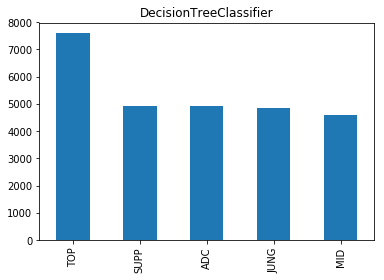

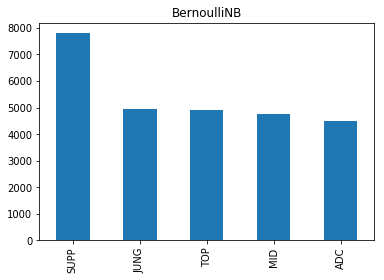

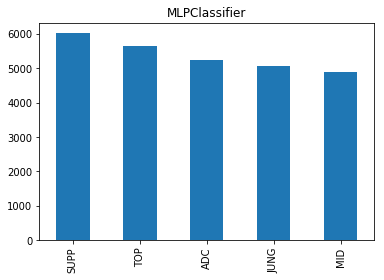

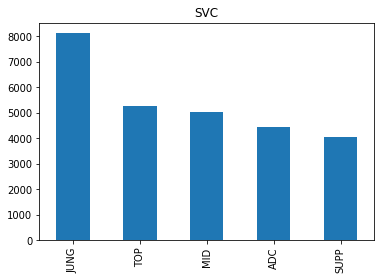

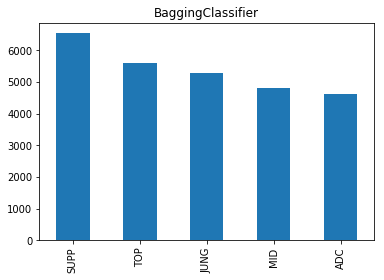

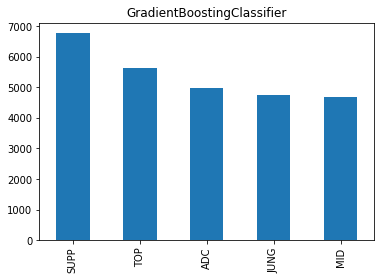

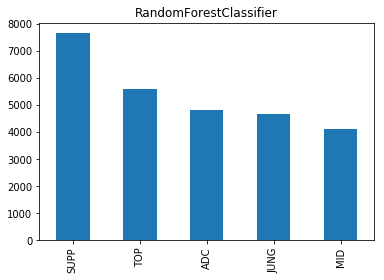

In [93]:
for model in models:
    model.fit(X=trainers, y=labels)
    predicts = model.predict(X=predictors)
    soloq_df['position'] = predicts
    
    m_name = str(model.__class__).split('\'')[-2].split('.')[-1]
    
    data = soloq_df.position.value_counts()
    data.plot(kind='bar', title=m_name)
    plt.show()
    
    soloq_df = soloq_df.assign(**{lane: 0 for lane in ['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']})
    pos_dums = soloq_df.position.str.get_dummies()
    dums_cols = pos_dums.columns.tolist()
    soloq_df[dums_cols] = pos_dums
    df_temp = soloq_df.groupby(['gameId', 'side']).sum()[['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']]
    df_temp['all_good'] = df_temp.apply(positions_assigned_correctly, axis=1)
    good_predicts = df_temp.all_good.count()
    
    list1.append({'model': m_name, 'predicts': predicts, 'good_predicts': good_predicts})

In [94]:
predicts_df = pd.DataFrame(list1)

In [95]:
for row in predicts_df.iterrows():
    print(row[1][0])
    print(pd.Series(row[1][1]).value_counts())
    print('\n')

5372
DecisionTreeClassifier    1
dtype: int64


5372
BernoulliNB    1
dtype: int64


5372
MLPClassifier    1
dtype: int64


5372
SVC    1
dtype: int64


5372
BaggingClassifier    1
dtype: int64


5372
GradientBoostingClassifier    1
dtype: int64


5372
RandomForestClassifier    1
dtype: int64




In [96]:
df_temp = pd.concat([soloq_df, soloq_df.position.str.get_dummies()], axis=1)

In [97]:
df_temp2 = df_temp.groupby(['gameId', 'side']).sum()[['ADC', 'JUNG', 'MID', 'SUPP', 'TOP']]

In [98]:
from numpy import std

In [99]:
def positions_assigned_correctly(x):
    if std(x.tolist()) != 0:
        return 0
    else:
        return 1
    

In [100]:
df_temp2['all_good'] = df_temp2.apply(positions_assigned_correctly, axis=1)

In [101]:
df_temp2.all_good.count()

5372